In [1]:
!pip install -q git+https://github.com/Watts-Lab/nomad.git@IC2S2-tutorial

import gdown
gdown.cached_download(
    "https://drive.google.com/uc?id=1wk3nrNsmAiBoTtWznHjjjPkmWAZfxk0P",
    path="IC2S2_2025.zip",
    quiet=False,
    postprocess=gdown.extractall,  # auto-unzip
)

ModuleNotFoundError: No module named 'gdown'

# **Tutorial 3: Stop detection in trajectories**

In this notebook we will explore some stop detection algorithms implemented in `nomad`. We will learn the differences between stop detection and traditional clustering algorithms, and the types of errors we need to watch out for. 

## Introduction

## Load data 

Let's use the same 3 week sample of data as in the previous notebook. Initially we will focus on data from a user in just one day, which we can filter at read time. 

In [2]:
import nomad.io.base as loader
import geopandas as gpd
from shapely.geometry import Polygon, box, Point


city = gpd.read_file("garden_city.geojson").to_crs('EPSG:3857')
outer_box = box(*city.total_bounds).buffer(15, join_style='mitre')

filepath_root = 'gc_data_long/'
tc = {
    "user_id": "gc_identifier",
    "timestamp": "unix_ts",
    "x": "dev_x",
    "y": "dev_y",
    "ha":"ha",
    "date":"date"}

users = ['admiring_brattain']
traj = loader.sample_from_file(filepath_root, format='parquet', users=users, filters = ('date','==', '2024-01-01'), traj_cols=tc)

Understanding the time component of the trajectory is important since the notion of a "stop" or a "visit" requires finding pings that indicate **stationary behavior**. Naturally this depends on the **pings being spatially close to one another, but also in the same period of time**. Let's try to visualize this temporal component on the map. 

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import shapely.plotting as shp_plt
from IPython.display import HTML

# small utility
from nomad.stop_detection.viz import adjust_zoom, plot_stops_barcode, plot_pings, plot_stops, plot_time_barcode

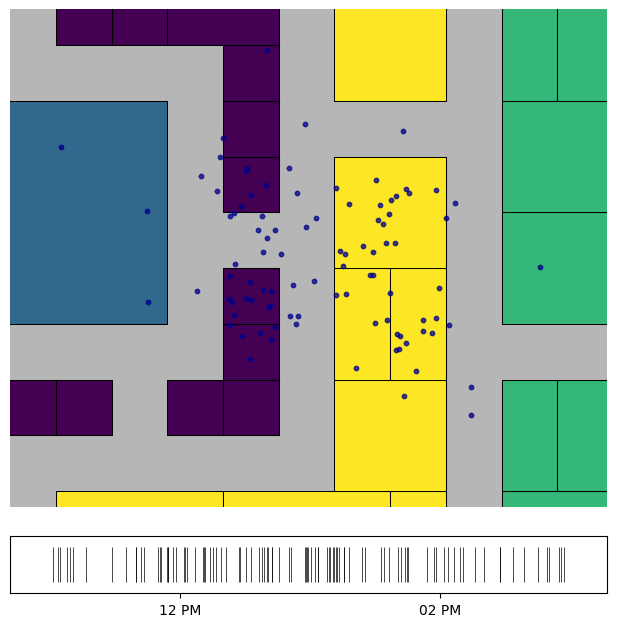

In [4]:
fig, (ax_map, ax_barcode) = plt.subplots(2, 1, figsize=(6,6.5), gridspec_kw={'height_ratios':[10,1]})

# Map
shp_plt.plot_polygon(outer_box, ax=ax_map, add_points=False, color='#0e0e0e')
city.plot(ax=ax_map, column='type', edgecolor='black', linewidth=0.75, cmap='viridis')
ax_map.scatter(traj['dev_x'], traj['dev_y'], s=10, color='darkblue', alpha=0.75)
adjust_zoom(traj['dev_x'], traj['dev_y'], buffer=0.8, ax=ax_map)
ax_map.set_axis_off()

plot_time_barcode(traj['unix_ts'], ax_barcode)

plt.tight_layout(pad=0.1)
plt.show()

We can see that the pings are very dense for this user and correspond (apparently) to **4 visits to close by locations**. We would like to have a clustering algorithm that can recover:
1. **Where** those stops took place (with a centroid for example)
2. **When** the stop started, and how long it lasted

<small>*Expand the cell bellow to see a small animation for the image above!

In [ ]:
fig, (ax_map, ax_barcode) = plt.subplots(2, 1, figsize=(6,6.5), gridspec_kw={'height_ratios':[10,1]})

# Map base
shp_plt.plot_polygon(outer_box, ax=ax_map, add_points=False, color='#0e0e0e')
city.plot(ax=ax_map, column='type', edgecolor='black', linewidth=0.75, cmap='Accent')
adjust_zoom(traj['dev_x'], traj['dev_y'], buffer=0.8, ax=ax_map)
ax_map.set_axis_off()
points = ax_map.scatter(traj['dev_x'], traj['dev_y'], s=10, color='darkblue', alpha=0.0)
current = ax_map.scatter([traj['dev_x'].iloc[0]], [traj['dev_y'].iloc[0]], s=50, color='red', alpha=1.0)

def animate(i):
    points.set_alpha([1.0 if j < i else 0.0 for j in range(len(traj))])
    current.set_offsets([[traj['dev_x'].iloc[i], traj['dev_y'].iloc[i]]])
    ax_barcode.cla()  # Clear barcode axis
    plot_time_barcode(traj['unix_ts'], ax_barcode, current_idx=i)  # Your function, highlights current in red
    return points, current

ani = animation.FuncAnimation(fig, animate, frames=len(traj), interval=120, blit=False)
plt.tight_layout(pad=0.1)

html = ani.to_html5_video() # capture the animation
plt.close(fig)
# finally display the video
HTML(html)

## Stop detection algorithms

In [ ]:
import nomad.stop_detection.dbscan as DBSCAN
import nomad.stop_detection.lachesis as LACHESIS
import nomad.stop_detection.grid_based as GRID_BASED
import nomad.filters as filters 

### Sequential stop detection

The first stop detection algorithm implemented in ```nomad``` is a sequential algorithm insipired by the one in _Project Lachesis: Parsing and Modeling Location Histories_ (Hariharan & Toyama). This algorithm for extracting stays is dependent on two parameters: the roaming distance and the stay duration. 

dur_min
* `delta_roam` is the Roaming distance ($\Delta_{\texttt{max}}$) represents the maximum distance an object can move away from a point location and still be considered to be staying at that location.
* `dur_min` is a minimum stop duration below which we consider the stop to be (potentially) spurious
* ```dt_max```: Maximum time gap permitted between consecutive pings in a stay in minutes (dt_max should be greater than dur_min).

The algorithm identifies stops as contiguous sequences of pings that have a diameter less than `delta_roam` for at least the duration of the stop duration.

In [ ]:
LACHESIS.lachesis(traj, delta_roam=20, dt_max = 60, dur_min=5, traj_cols=tc) # Try passing keep_col_names = False

Optionally, we can get some useful statistics about each stop with the argument `complete_output`

In [ ]:
stops = LACHESIS.lachesis(traj, delta_roam=20, dt_max = 60, dur_min=5, complete_output=True, keep_col_names=True, traj_cols=tc)
stops

The diameter column can give us a notion of the extent of the stop. Larger stops reveal less precise information and could be evidence of **merging** two true stops. We can visualize them as circles with radius `stops['diameter']/2`

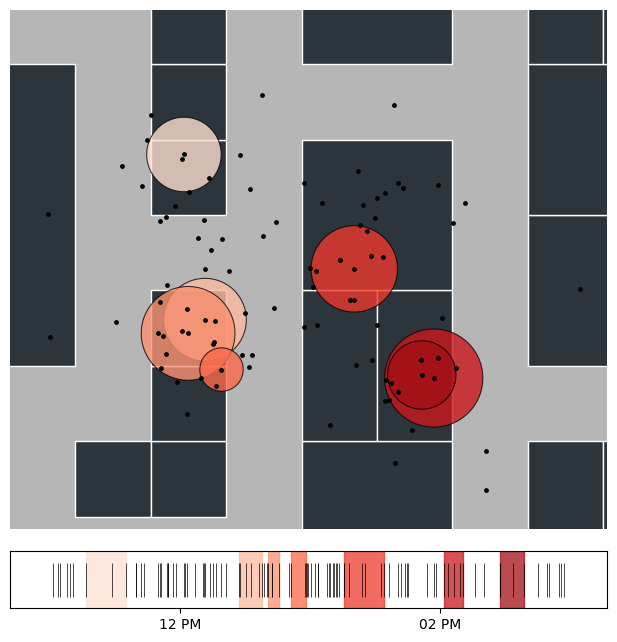

In [ ]:
fig, (ax_map, ax_barcode) = plt.subplots(2, 1, figsize=(6,6.5),
                                         gridspec_kw={'height_ratios':[10,1]})

shp_plt.plot_polygon(outer_box, ax=ax_map, add_points=False, color='#0e0e0e')
city.plot(ax=ax_map, edgecolor='white', linewidth=1, color='#2c353c')

plot_stops(stops, ax=ax_map, cmap='Reds', x='dev_x', y='dev_y')
plot_pings(traj, ax=ax_map, s=6, point_color='black', cmap='twilight', traj_cols=tc)

adjust_zoom(stops['dev_x'], stops['dev_y'], buffer=1.4, ax=ax_map)
ax_map.set_axis_off()

plot_time_barcode(traj[tc['timestamp']], ax=ax_barcode, set_xlim=True)
plot_stops_barcode(stops, ax=ax_barcode, cmap='Reds', set_xlim=False, x='x', y='y', timestamp='unix_ts')

plt.tight_layout(pad=0.1)
plt.show()

### Flexibility in input formats 

The stop detection algorithms implemented in `nomad` support different combinations of input formats that are common in commercial datasets, detecting default names when possible
- timestamps in `datetime64[ns, tz]` or as unix seconds in integers
- geographic coordinates (`lon`, `lat`) which use the Haversine distance or projected coordinates (`x`, `y`) using meters and euclidean distance.
- Alternatively, if locations are only given through a spatial index like H3 or geohash, there is a **grid_based** clustering algorithm requiring no coordinates. 

The algorithms work with the same call, provided there is at least a pair of coordinates (or a location/spatial index) as well as at least a temporal column.

In [26]:
traj['h3_cell'] = filters.to_tessellation(traj, index="h3", res=10, latitude='latitude', longitude='longitude')
traj['h3_cell']

0        8a3593605ad7fff
1        8a3593605adffff
2        8a3593605adffff
3        8a3593605adffff
4        8a3593605adffff
              ...       
58790    8a3593605ac7fff
58791    8a3593605ac7fff
58792    8a3593605ac7fff
58793    8a3593605ac7fff
58794    8a3593605ac7fff
Name: h3_cell, Length: 58795, dtype: object

In [ ]:
import numpy as np
import pandas as pd
pd.set_option("mode.copy_on_write", True)
import h3

traj[['longitude','latitude']] = np.column_stack(
    filters.to_projection(traj, x='dev_x', y='dev_y', data_crs='EPSG:3857', crs_to='EPSG:4326')
)

traj['zoned_datetime'] = pd.to_datetime(traj['unix_ts'], unit='s', utc=True).dt.tz_convert('Etc/GMT-1')
traj['h3_cell'] = filters.to_tessellation(traj, index="h3", res=10, latitude='latitude', longitude='longitude')

# Alternate datasets 
traj_geog = traj[['latitude', 'longitude', 'zoned_datetime']]
traj_h3 = traj[['gc_identifier', 'unix_ts', 'h3_cell']]

# Very similar call
stops_lac =  LACHESIS.lachesis(traj_geog, delta_roam=25, dt_max = 45, dur_min=3, complete_output=True, latitude='latitude', longitude='longitude', datetime='zoned_datetime')
traj_geog['cluster'] = LACHESIS.lachesis_labels(traj_geog, delta_roam=25, dt_max = 45, dur_min=3, latitude='latitude', longitude='longitude', datetime='zoned_datetime')

stops_h3 = GRID_BASED.grid_based(traj_h3, time_thresh=180, dur_min=3, complete_output=True, timestamp='unix_ts', location_id='h3_cell')
traj_h3['cluster'] = GRID_BASED.grid_based_labels(traj_h3, time_thresh=180, dur_min=3, timestamp='unix_ts', location_id='h3_cell')

In [11]:
%load_ext autoreload
%autoreload 2

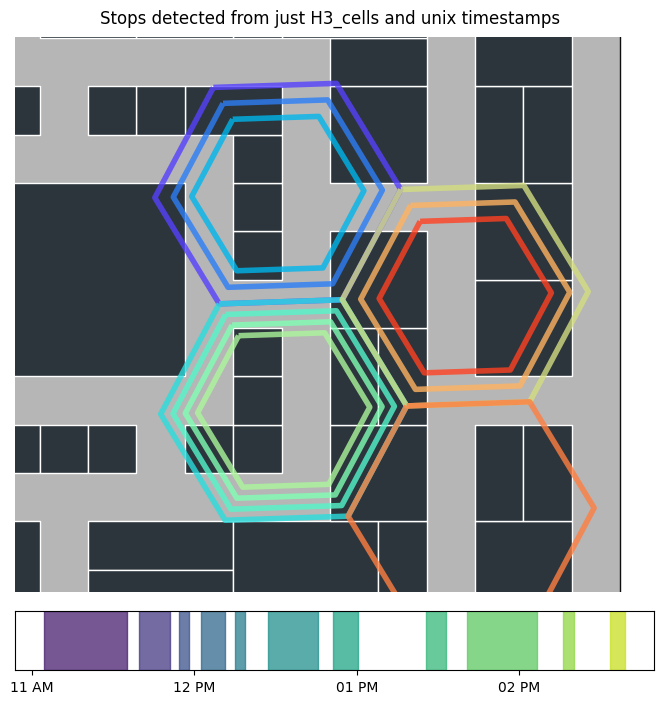

In [ ]:
traj_h3[['dev_x','dev_y']] = traj[['dev_x','dev_y']]

fig, (ax_map, ax_barcode) = plt.subplots(2, 1, figsize=(6.5,7),
                                         gridspec_kw={'height_ratios':[10,1]})

shp_plt.plot_polygon(outer_box, ax=ax_map, add_points=False, color='#0e0e0e')
city.plot(ax=ax_map, edgecolor='white', linewidth=1, color='#2c353c')

plot_stops(stops_h3, ax=ax_map, cmap='rainbow', location_id='h3_cell', crs='EPSG:3857', edge_only=True)
#plot_pings(traj_h3, ax=ax_map, point_color='black', cmap="rainbow", radius=2, s=5, circle_alpha=0.5, traj_cols=tc)

adjust_zoom(stops['dev_x'], stops['dev_y'], buffer=3, ax=ax_map)
ax_map.set_axis_off()

#plot_time_barcode(traj_h3[tc['timestamp']], ax=ax_barcode, set_xlim=True)
plot_stops_barcode(stops_h3, ax=ax_barcode, cmap='viridis', set_xlim=False, timestamp='unix_ts')

fig.suptitle("Stops detected from just H3_cells and unix timestamps")
plt.tight_layout(pad=0.1)
plt.show()

**Fig 2. Possible problems when applying stop detection to be aware of. How to parameterize optimally?**
    
![title](figures/stop-detection-problems.png)

### Density based stop detection (Temporal DBSCAN)

The second stop detection algorithm implemented in ```nomad``` is an adaptation of DBSCAN. Unlike in plain DBSCAN, we also incorporate the time dimension to determine if two pings are "neighbors". This implementation relies on 3 parameters

* `time_thresh` defines the maximum time difference (in minutes) between two consecutive pings for them to be considered neighbors within the same cluster.
* `dist_thresh` specifies the maximum spatial distance (in meters) between two pings for them to be considered neighbors.
* `min_pts` sets the minimum number of neighbors required for a ping to form a cluster.

Notice that this method also works with **geographic coordinates** (lon, lat), using Haversine distance. 

In [ ]:
users = ['confident_aryabhata']
traj = loader.sample_from_file(filepath_root, format='parquet', users=users, filters = ('date','<=', '2024-01-03'), traj_cols=tc)
traj[['longitude','latitude']] = np.column_stack(
    filters.to_projection(traj, x='dev_x', y='dev_y', data_crs='EPSG:3857', crs_to='EPSG:4326')
)

In [ ]:
stops_dbscan = DBSCAN.ta_dbscan(traj,
                    time_thresh=720,
                    dist_thresh=15,
                    min_pts=3,
                    complete_output=True,
                    traj_cols=tc)

fig, ax_barcode = plt.subplots(figsize=(10,1.5))

plot_time_barcode(traj['unix_ts'], ax=ax_barcode, set_xlim=True)
plot_stops_barcode(stops_dbscan, ax=ax_barcode, stop_color='red', set_xlim=False, timestamp='unix_ts')
fig.suptitle("Overlapping stops")
plt.tight_layout()
plt.show()

In [ ]:
import nomad.stop_detection.postprocessing as post

post.invalid_stops(stops_dbscan, print_stops=True, **tc)
stops_dbscan.loc[stops_dbscan.unix_ts.isin([1704197861, 1704242618])]

## Spatial-only algorithms can produce (temporally) invalid stop tables

While the parameter `time_thresh` helps mitigate this issue (this would be *pre-processing*). It seems like some post-processing is necessary to "break up" temporally overlapping stops. 

One way is to use a **sequential location-based algorithm**, using DBSCAN's cluster labels **as "locations"**. For this we need the **disaggregated output** of the stop-detection algorithm

In [ ]:
traj["cluster"] = DBSCAN.ta_dbscan_labels(traj,
                    time_thresh=720,
                    dist_thresh=15,
                    min_pts=3,
                    traj_cols=tc)

## Uncomment to see label counts
# traj.cluster.value_counts()

In [17]:
traj

,gc_identifier,dev_x,dev_y,unix_ts,ha,tz_offset,date,longitude,latitude,cluster
0,confident_aryabhata,-4.265516e+06,4.393040e+06,1704111151,9.940171,-14400,2024-01-01,-38.317783,36.668785,0
1,confident_aryabhata,-4.265521e+06,4.393051e+06,1704111275,12.917403,-14400,2024-01-01,-38.317828,36.668866,0
2,confident_aryabhata,-4.265521e+06,4.393061e+06,1704111660,9.529149,-14400,2024-01-01,-38.317826,36.668937,0
3,confident_aryabhata,-4.265510e+06,4.393068e+06,1704111704,10.096338,-14400,2024-01-01,-38.317727,36.668989,0
4,confident_aryabhata,-4.265505e+06,4.393050e+06,1704111741,13.339782,-14400,2024-01-01,-38.317688,36.668856,0
...,...,...,...,...,...,...,...,...,...,...
396,confident_aryabhata,-4.265566e+06,4.393104e+06,1704338918,15.048051,-14400,2024-01-03,-38.318228,36.669250,1
397,confident_aryabhata,-4.265562e+06,4.393088e+06,1704339010,9.201426,-14400,2024-01-03,-38.318194,36.669136,1
398,confident_aryabhata,-4.265554e+06,4.393088e+06,1704339350,8.434094,-14400,2024-01-03,-38.318120,36.669136,1
399,confident_aryabhata,-4.265569e+06,4.393087e+06,1704340058,8.223668,-14400,2024-01-03,-38.318262,36.669123,1


In [ ]:
from nomad.stop_detection.utils import summarize_stop

new_cluster = GRID_BASED.grid_based_labels(
                        data=traj.loc[traj.cluster!=-1], # except noise pings
                        time_thresh=720,
                        min_cluster_size=3,
                        location_id="cluster", # grid_based requires a location column
                        traj_cols=tc)

traj.loc[traj.cluster!=-1, 'cluster'] = new_cluster

In [ ]:
post_processed_stops = [
        summarize_stop(
            grouped_data=group,
            keep_col_names=True,
            complete_output=True,
            traj_cols=tc,
            passthrough_cols = ['cluster', 'gc_identifier']
        )
        for _, group in traj.loc[traj.cluster!=-1].groupby('cluster', as_index=False, sort=False)
    ]
post_processed_stops = pd.DataFrame(post_processed_stops)

print("Invalid stops?")
post.invalid_stops(post_processed_stops, print_stops=True, **tc)

In [ ]:
fig, ax_barcode = plt.subplots(figsize=(10,1.5))

plot_time_barcode(traj['unix_ts'], ax=ax_barcode, set_xlim=True)
plot_stops_barcode(post_processed_stops, ax=ax_barcode, stop_color='blue', set_xlim=False, timestamp='unix_ts')
fig.suptitle("DBSCAN stops with post-processing")
plt.tight_layout()
plt.show()

This post-processing is also wrapped in the method `nomad.stop_detection.postprocessing.remove_overlaps`

In [ ]:
# post_processed_stops = post.remove_overlaps(traj, time_thresh=720, method='cluster', traj_cols=tc)

## Which algorithm to choose? which parameters

This is not a trivial problem and researchers often rely on "trial and error" or, worse, default parameters. A semi-informed choice could depend on:


| Factor | Implication |
| --- | --- |
| Signal sparsity | Denser data → increase DBSCAN `min_pts` to prevent over‑clustering |
| Noise level | Higher noise (low accuracy) → use larger distance thresholds |
| Building proximity | Dense areas → use smaller distance thresholds |
| Scalability | More robust methods → longer execution time |

We could do **a parameter search** by keeping track of some statistics of the output of several stop detection algorithms

In [ ]:
traj = loader.sample_from_file(filepath_root, frac_users=0.1, format='parquet', traj_cols=tc, seed=10) # try frac_users = 0.1

# H3 cells for grid_based stop detection method
traj['h3_cell'] = filters.to_tessellation(traj, index="h3", res=10, x='dev_x', y='dev_y', data_crs='EPSG:3857')
pings_per_user = traj['gc_identifier'].value_counts()

In [ ]:
import time
from tqdm import tqdm
import nomad.stop_detection.hdbscan as HDBSCAN

# Approximately 5 minutes for 40 users
results = []
for user, n_pings in tqdm(pings_per_user.items(), total=len(pings_per_user)):
    user_data = traj.query("gc_identifier == @user")

    # For location based
    start_time = time.time()
    stops_gb = GRID_BASED.grid_based(user_data, time_thresh=240, complete_output=True, timestamp='unix_ts', location_id='h3_cell')
    execution_time = time.time() - start_time
    results += [pd.Series({'user':user, 'algo':'grid_based', 'execution_time':execution_time, 'total_dwell':stops_gb.duration.sum(), 'avg_diameter':52, 'n_pings':n_pings})]
    
    # For Lachesis
    start_time = time.time()
    stops_lac = LACHESIS.lachesis(user_data, delta_roam=30, dt_max=240, complete_output=True, traj_cols=tc)
    execution_time = time.time() - start_time
    results += [pd.Series({'user':user, 'algo':'lachesis', 'execution_time':execution_time, 'total_dwell':stops_lac.duration.sum(), 'avg_diameter':stops_lac.diameter.mean(), 'n_pings':n_pings})]

    # For TADbscan
    start_time = time.time()
    user_data_tadb = user_data.assign(cluster=DBSCAN.ta_dbscan_labels(user_data, time_thresh=240, dist_thresh=15, min_pts=3, traj_cols=tc))
    # - post-processing
    stops_tadb = post.remove_overlaps(user_data_tadb, time_thresh=240, method='cluster', traj_cols=tc)
    execution_time = time.time() - start_time
    results += [pd.Series({'user':user, 'algo':'tadbscan', 'execution_time':execution_time, 'total_dwell':stops_tadb.duration.sum(), 'avg_diameter':stops_tadb.diameter.mean(), 'n_pings':n_pings})]

    # For HDBSCAN
    start_time = time.time()
    user_data_hdb = user_data.assign(cluster=HDBSCAN.st_hdbscan_labels(user_data, time_thresh=240, min_pts=3, min_cluster_size=2, traj_cols=tc))
    # - post-processing
    stops_hdb = post.remove_overlaps(user_data_hdb, time_thresh=240, method='cluster', traj_cols=tc)    
    execution_time = time.time() - start_time
    results += [pd.Series({'user':user, 'algo':'hdbscan', 'execution_time':execution_time, 'total_dwell':stops_hdb.duration.sum(), 'avg_diameter':stops_hdb.diameter.mean(), 'n_pings':n_pings})]

results = pd.DataFrame(results)

,user,algo,execution_time,total_dwell,avg_diameter,n_pings
0,gifted_galileo,grid_based,0.316073,20853,52.000000,6124
1,gifted_galileo,lachesis,5.207263,14933,25.105149,6124
2,gifted_galileo,tadbscan,2.299535,20766,44.163751,6124
3,gifted_galileo,hdbscan,21.919378,20989,53.370742,6124
4,gallant_elbakyan,grid_based,0.318075,20609,52.000000,6060
5,gallant_elbakyan,lachesis,6.869707,15297,24.939732,6060
6,gallant_elbakyan,tadbscan,2.199512,22209,43.159734,6060
7,gallant_elbakyan,hdbscan,21.117564,22276,54.989075,6060
8,inspiring_visvesvaraya,grid_based,0.242058,13770,52.000000,5049
9,inspiring_visvesvaraya,lachesis,4.152974,8901,24.958309,5049


### Use **completeness to normalize** ('hrs with data' / 'total hrs')

In [ ]:
completeness_per_user = filters.completeness(traj, timestamp='unix_ts', user_id='gc_identifier')
dwell_scaling = 1/completeness_per_user
dwell_scaling.name = 'dwell_scaling'

metrics = pd.merge(results, dwell_scaling, left_on='user', right_index=True)
metrics['rescaled_total_dwell'] = (metrics['total_dwell']/60)*metrics['dwell_scaling'] # in hours

In [ ]:
import seaborn as sns

algos = ['grid_based', 'lachesis', 'tadbscan', 'hdbscan']
palette = dict(zip(algos, sns.color_palette(n_colors=len(algos))))

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# scatter: n_pings vs execution_time
sns.scatterplot(data=metrics, x='n_pings', y='execution_time', hue='algo', ax=axes[0])
axes[0].set_title('n_pings vs execution_time')

# density: avg_diameter
sns.kdeplot(data=metrics, x='avg_diameter', hue='algo', ax=axes[1], common_norm=False, bw_adjust=2)
for algo, color in palette.items():
    med = metrics.loc[metrics.algo == algo, 'avg_diameter'].median()
    axes[1].axvline(med, color=color, linestyle='--')
    
axes[1].set_title('average stop diameter (m)')

# density: rescaled_total_dwell
sns.kdeplot(data=metrics, x='rescaled_total_dwell', hue='algo', ax=axes[2], common_norm=False)
axes[2].set_title('total dwell time (h) rescaled')

plt.tight_layout()
plt.show()

## Export stops for next notebook

In [23]:
%%time
# takes approximately 6 min
traj = loader.from_file(filepath_root, format='parquet', traj_cols=tc)

all_stops = LACHESIS.lachesis_per_user(traj, delta_roam=30, dt_max=240, complete_output=True, keep_col_names=False, passthrough_cols=['tz_offset'], traj_cols=tc)

loader.to_file(all_stops, "gc_data_stops/", format="parquet", partition_by=["gc_identifier"], existing_data_behavior='overwrite_or_ignore', user_id='gc_identifier')

CPU times: total: 6min 29s
Wall time: 6min 29s
